### This is a notebook that primarily examines moller invariant mass distributions for 2021 1.92GeV Montecarlo and Data using dataframes as the primary analysis method. In order to run this notebook, a custom ROOT Moller Macro must be compiled. It can be found here: https://github.com/JeffersonLab/hps-analysis/tree/master/Moller

In [1]:
import sys
import ROOT as R
%jsroot off

R.gSystem.Load("libMoller") #loads the Moller C++ class required to do this analysis in a semi-compact way in a notebook.
Moller = R.Moller()
print("Version of Moller Class:",Moller.GetVersion())

Welcome to JupyROOT 6.28/02
Version of Moller Class: 1.0


In [2]:
#load MC files into a dataframe
moller_beam_files1 = "/mnt/e/moller/moller_pulser/root/moller_pulser1_concat.root"
moller_beam_files2 = "/mnt/e/moller/moller_pulser/root/moller_pulser3_concat.root"
ch_moller_beam = R.TChain("MiniDST")
ch_moller_beam.Add(moller_beam_files1)
ch_moller_beam.Add(moller_beam_files2)
n_events_beam = ch_moller_beam.GetEntries()
df_moller_beam = R.RDataFrame(ch_moller_beam)
print(f"Moller + Beam backround MC: total of {n_events_beam/1e6:7.2f}M events")

#load 2021 data files into a dataframe
moller_data_files = "/mnt/e/Moller/2021_data/*.root"
ch_moller_data = R.TChain("MiniDST")
ch_moller_data.Add(moller_data_files)
#.Add(moller_data_files2)
df_data = R.RDataFrame(ch_moller_data)
n_events_data = ch_moller_data.GetEntries()
print(f"Moller data: total of {n_events_data/1e6:7.2f}M events")


Moller + Beam backround MC: total of    0.34M events
Moller data: total of   14.27M events


In [3]:
#creates an individual DF for each kind of vertex: UC, BSC, TC. A df is also created without the use of vertexing

Beam_Energy = 1.9

#MC dfs
df_uc = Moller.Select_v0(R.RDF.AsRNode(df_moller_beam), 4, 0., 2.5,"pairs") \
    .Define("n_moller_pair","return pairs_idx.size();").Filter("n_moller_pair >= 1")

df_bsc = Moller.Select_v0(R.RDF.AsRNode(df_moller_beam), 5, 0., 2.5,"pairs") \
    .Define("n_moller_pair","return pairs_idx.size();").Filter("n_moller_pair >= 1")

df_tc = Moller.Select_v0(R.RDF.AsRNode(df_moller_beam), 6, 0., 2.5,"pairs") \
    .Define("n_moller_pair","return pairs_idx.size();").Filter("n_moller_pair >= 1")

df_nov = Moller.Select_El_Pairs(R.RDF.AsRNode(df_moller_beam), 0., 2.5,"pairs")\
    .Define("n_moller_pair","return pairs.size();").Filter("n_moller_pair >= 1")

#data dfs
df_uc_data = Moller.Select_v0(R.RDF.AsRNode(df_data), 4, 0., 2.5,"pairs") \
    .Define("n_moller_pair","return pairs_idx.size();").Filter("n_moller_pair >= 1")

df_bsc_data = Moller.Select_v0(R.RDF.AsRNode(df_data), 5, 0., 2.5,"pairs") \
    .Define("n_moller_pair","return pairs_idx.size();").Filter("n_moller_pair >= 1")

df_tc_data = Moller.Select_v0(R.RDF.AsRNode(df_data), 6, 0., 2.5,"pairs") \
    .Define("n_moller_pair","return pairs_idx.size();").Filter("n_moller_pair >= 1")

df_nov_data = Moller.Select_El_Pairs(R.RDF.AsRNode(df_data), 0., 2.5,"pairs")\
    .Define("n_moller_pair","return pairs.size();").Filter("n_moller_pair >= 1")

In [4]:
#performs the cuts sequentially on each of the dfs in the cell above. 
data_set = [df_uc, df_bsc,df_tc,df_nov,df_uc_data,df_bsc_data,df_tc_data,df_nov_data]
for i in range(len(data_set)):
    data_set[i] = Moller.Add_Four_Vectors(R.RDF.AsRNode(data_set[i]), -0.0302, "pairs","part_","p4")
    data_set[i] = Moller.Refine_El_Pairs_1(R.RDF.AsRNode(data_set[i]), 1.7, Beam_Energy*0., Beam_Energy*2., "pairs", "pairs_idx", "pairs_r1")
    data_set[i] = Moller.Refine_El_Pairs_2(R.RDF.AsRNode(data_set[i]), "pairs", "pairs_r1", "pairs_r2")
    data_set[i] = Moller.Refine_El_Pairs_3(R.RDF.AsRNode(data_set[i]), 0.01, "pairs_r2", "p4", "pairs_r3")
    data_set[i] = Moller.Refine_El_Pairs_1(R.RDF.AsRNode(data_set[i]), 2.0, Beam_Energy*0.85, Beam_Energy*1.15, "pairs", "pairs_r3", "pairs_r4")
    data_set[i] = Moller.Refine_El_Pairs_X2(R.RDF.AsRNode(data_set[i]), "pairs", "pairs_r4", "pairs_rx")


[df_uc, df_bsc,df_tc,df_nov,df_uc_data,df_bsc_data,df_tc_data,df_nov_data] = data_set

In [5]:
# extract vertex position information from moller pairs that pass a specific cut. in this case, we are interested in pairs that pass R4 and RX.
for i in range(len(data_set)):
    data_set[i] = data_set[i].Define('vertex_x',"vector<double> out;for(int i: pairs_r4) out.push_back(v0_vertex_x[i]);return out;")\
             .Define('vertex_y',"vector<double> out;for(int i: pairs_r4) out.push_back(v0_vertex_y[i]);return out;")\
             .Define('vertex_z',"vector<double> out;for(int i: pairs_r4) out.push_back(v0_vertex_z[i]);return out;")\
             .Define('v0_radius',"vector<double> out;for(int i:pairs_r4) out.push_back(sqrt(v0_vertex_x[i]*v0_vertex_x[i] + v0_vertex_y[i]*v0_vertex_y[i]));return out;")\
             .Define('rx_x',"vector<double> out;for(int i: pairs_rx) out.push_back(v0_vertex_x[i]);return out;")\
             .Define('rx_y',"vector<double> out;for(int i: pairs_rx) out.push_back(v0_vertex_y[i]);return out;")\
             .Define('rx_z',"vector<double> out;for(int i: pairs_rx) out.push_back(v0_vertex_z[i]);return out;")\
             .Define('rx_radius',"vector<double> out;for(int i:pairs_rx) out.push_back(sqrt(v0_vertex_x[i]*v0_vertex_x[i] + v0_vertex_y[i]*v0_vertex_y[i]));return out;")\

[df_uc, df_bsc,df_tc,df_nov,df_uc_data,df_bsc_data,df_tc_data,df_nov_data] = data_set

In [6]:
# R4 pair vertex position plots for both MC and Data
h_uc_XY = df_uc.Histo2D(('h_uc_xy','MC UC vertex XY;X;Y',1000,-2,2,1000,-2,2),'vertex_x','vertex_y')
h_bsc_XY = df_bsc.Histo2D(('h_bsc_xy','MC BSC vertex XY;X;Y',1000,-2,2,1000,-2,2),'vertex_x','vertex_y')
h_tc_XY = df_tc.Histo2D(('h_tc_xy','MC TC vertex XY;X;Y',1000,-2,2,1000,-2,2),'vertex_x','vertex_y')

h_uc_radius = df_uc.Histo1D(('h_uc_rad','UC vertex radius;Vertex radius',100,0,5),'v0_radius') 
h_bsc_radius = df_bsc.Histo1D(('h_bsc_rad',' BSC vertex radius;Vertex radius',100,0,2),'v0_radius')
h_tc_radius = df_tc.Histo1D(('h_tc_xy','TC vertex radius;Vertex radius',100,0,.2),'v0_radius')

h_uc_rad_vs_z = df_uc.Histo2D(('h_uc_rad_vs_z','MC UC vertex radius vs z;Vertex Z;Vertex XY-Radius',100,-50,50,100,0,2.5),'vertex_z','v0_radius')
h_bsc_rad_vs_z = df_bsc.Histo2D(('h_bsc_rad_vs_z','MC BSC vertex radius vs z;Vertex Z;Vertex XY-Radius',100,-50,50,100,0,2.5),'vertex_z','v0_radius')
h_tc_rad_vs_z = df_tc.Histo2D(('h_tc_rad_vs_z','MC TC vertex radius vs z;Vertex Z;Vertex XY-Radius',100000,-50,50,100,0,.1),'vertex_z','v0_radius')

h_uc_Z = df_uc.Histo1D(('h_uc_vertex_z','MC UC vertex z;vertex Z',100,-50,50),'vertex_z')
h_bsc_Z = df_bsc.Histo1D(('h_bsc_vertex_z','MC BSC vertex z;vertex Z',100,-50,50),'vertex_z')
h_tc_Z = df_tc.Histo1D(('h_tc_vertex_z','MC TC vertex z;vertex Z',100,-50,50),'vertex_z')

h_uc_XY_data = df_uc_data.Histo2D(('h_uc_xy','DATA UC vertex XY;X;Y',1000,-2,2,1000,-2,2),'vertex_x','vertex_y')
h_bsc_XY_data = df_bsc_data.Histo2D(('h_bsc_xy','DATA BSC vertex XY;X;Y',1000,-2,2,1000,-2,2),'vertex_x','vertex_y')
h_tc_XY_data = df_tc_data.Histo2D(('h_tc_xy','DATA TC vertex XY;X;Y',1000,-2,2,1000,-2,2),'vertex_x','vertex_y')

h_uc_radius_data = df_uc_data.Histo1D(('h_uc_rad','DATA uc vertex radius;Vertex radius',100,0,5),'v0_radius') 
h_bsc_radius_data = df_bsc_data.Histo1D(('h_bsc_rad','DATA BSC vertex radius;Vertex radius',100,0,2),'v0_radius')
h_tc_radius_data = df_tc_data.Histo1D(('h_tc_xy','DATA TC vertex radius;Vertex radius',100,0,.2),'v0_radius')

h_uc_rad_vs_z_data = df_uc_data.Histo2D(('h_uc_rad_vs_z','DATA UC vertex radius vs z;Vertex Z;Vertex XY-Radius',100,-50,50,100,0,2.5),'vertex_z','v0_radius')
h_bsc_rad_vs_z_data = df_bsc_data.Histo2D(('h_bsc_rad_vs_z','DATA BSC vertex radius vs z;Vertex Z;Vertex XY-Radius',100,-50,50,100,0,2.5),'vertex_z','v0_radius')
h_tc_rad_vs_z_data = df_tc_data.Histo2D(('h_tc_rad_vs_z','DATA TC vertex radius vs z;Vertex Z;Vertex XY-Radius',100,-10,0,100,0,.5),'vertex_z','v0_radius')

h_uc_Z_data = df_uc_data.Histo1D(('h_uc_vertex_z','DATA UC vertex z;vertex Z',100,-50,50),'vertex_z')
h_bsc_Z_data = df_bsc_data.Histo1D(('h_bsc_vertex_z','DATA BSC vertex z;vertex Z',100,-50,50),'vertex_z')
h_tc_Z_data = df_tc_data.Histo1D(('h_tc_vertex_z','DATA TC vertex z;vertex Z',100,-50,50),'vertex_z')
#######################################################################################################################################################################

# RX pair vertex position plots for both MC and Data
h_uc_XY_rx = df_uc.Histo2D(('h_uc_xy_rx','MC UC RX vertex XY;X;Y',1000,-2,2,1000,-2,2),'rx_x','rx_y')
h_bsc_XY_rx = df_bsc.Histo2D(('h_bsc_xy_rx','MC BSC rX vertex XY;X;Y',1000,-2,2,1000,-2,2),'rx_x','rx_y')
h_tc_XY_rx = df_tc.Histo2D(('h_tc_xy_rx','MC TC RX vertex XY;X;Y',1000,-2,2,1000,-2,2),'rx_x','rx_y')

h_uc_radius_rx = df_uc.Histo1D(('h_uc_rad','UC vertex radius_rx;Vertex radius',100,0,5),'rx_radius') 
h_bsc_radius = df_bsc.Histo1D(('h_bsc_rad',' BSC vertex radius_rx;Vertex radius',100,0,2),'rx_radius')
h_tc_radius = df_tc.Histo1D(('h_tc_xy','TC vertex radius_rx;Vertex radius',100,0,.2),'rx_radius')

h_uc_rad_vs_z_rx = df_uc.Histo2D(('h_uc_rad_vs_z_rx','MC UC RX vertex radius vs z;Vertex Z;Vertex XY-Radius',100,-50,50,100,0,2.5),'rx_z','rx_radius')
h_bsc_rad_vs_z_rx = df_bsc.Histo2D(('h_bsc_rad_vs_z_rx','MC BSC RX vertex radius vs z;Vertex Z;Vertex XY-Radius',100,-50,50,100,0,2.5),'rx_z','rx_radius')
h_tc_rad_vs_z_rx = df_tc.Histo2D(('h_tc_rad_vs_z_rx','MC TC RX vertex radius vs z;Vertex Z;Vertex XY-Radius',100000,-50,50,100,0,.1),'rx_z','rx_radius')

h_uc_Z_rx = df_uc.Histo1D(('h_uc_vertex_z_rx','MC UC RX vertex z;vertex Z',100,-10,100),'rx_z')
h_bsc_Z_rx = df_bsc.Histo1D(('h_bsc_vertex_z_rx','MC BSC RX vertex z;vertex Z',100,-100,100),'rx_z')
h_tc_Z_rx = df_tc.Histo1D(('h_tc_vertex_z_rx','MC TC RX vertex z;vertex Z',100,-100,100),'rx_z')

h_uc_XY_data_rx = df_uc_data.Histo2D(('h_uc_xy_rx','DATA UC RX vertex XY;X;Y',1000,-2,2,1000,-2,2),'rx_x','rx_y')
h_bsc_XY_data_rx = df_bsc_data.Histo2D(('h_bsc_xy_rx','DATA BSC RX vertex XY;X;Y',1000,-2,2,1000,-2,2),'rx_x','rx_y')
h_tc_XY_data_rx = df_tc_data.Histo2D(('h_tc_xy_rx','DATA TC RX vertex XY;X;Y',1000,-2,2,1000,-2,2),'rx_x','rx_y')

h_uc_radius_data_rx = df_uc_data.Histo1D(('h_uc_rad_rx','DATA UC RX vertex radius;Vertex radius',100,0,5),'rx_radius') 
h_bsc_radius_data_rx = df_bsc_data.Histo1D(('h_bsc_rad_rx','DATA BSC RX vertex radius;Vertex radius',100,0,2),'rx_radius')
h_tc_radius_data_rx = df_tc_data.Histo1D(('h_tc_xy_rx','DATA TC RX vertex radius;Vertex radius',100,0,.2),'rx_radius')

h_uc_rad_vs_z_data_rx = df_uc_data.Histo2D(('h_uc_rad_vs_z_rx','DATA UC RX vertex radius vs z;Vertex Z;Vertex XY-Radius',100,-50,50,100,0,2.5),'rx_z','rx_radius')
h_bsc_rad_vs_z_data_rx = df_bsc_data.Histo2D(('h_bsc_rad_vs_z_rx','DATA BSC RX vertex radius vs z;Vertex Z;Vertex XY-Radius',100,-50,50,100,0,2.5),'rx_z','rx_radius')
h_tc_rad_vs_z_data_rx = df_tc_data.Histo2D(('h_tc_rad_vs_z_rx','DATA TC RX vertex radius vs z;Vertex Z;Vertex XY-Radius',100,-10,0,100,0,.5),'rx_z','rx_radius')

h_uc_Z_data_rx = df_uc_data.Histo1D(('h_uc_vertex_z_rx','DATA UC RX vertex z;vertex Z',100,-100,100),'rx_z')
h_bsc_Z_data_rx = df_bsc_data.Histo1D(('h_bsc_vertex_z_rx','DATA BSC RX vertex z;vertex Z',100,-100,100),'rx_z')
h_tc_Z_data_rx = df_tc_data.Histo1D(('h_tc_vertex_z_rx','DATA TC RX vertex z;vertex Z',100,-100,100),'rx_z')



In [ ]:
# plotting data vertex position information for pairs that passed the R4 cut.
C01 = R.TCanvas("C01","C01", 1200, 800)
C01.Divide(3,2)
p1 = C01.cd(1)
h_uc_XY_data.Draw('colz')
p2 = C01.cd(2)
h_bsc_XY_data.Draw('colz')
p3 = C01.cd(3)
h_tc_XY_data.Draw('colz')
p4 = C01.cd(4)
h_uc_rad_vs_z_data.Draw('colz')
p5 = C01.cd(5)
h_bsc_rad_vs_z_data.Draw('colz')
p6 = C01.cd(6)
h_tc_rad_vs_z_data.Draw('colz')
C01.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: C02
Info in <TCanvas::Print>: pdf file mc_vertex_info.pdf has been created


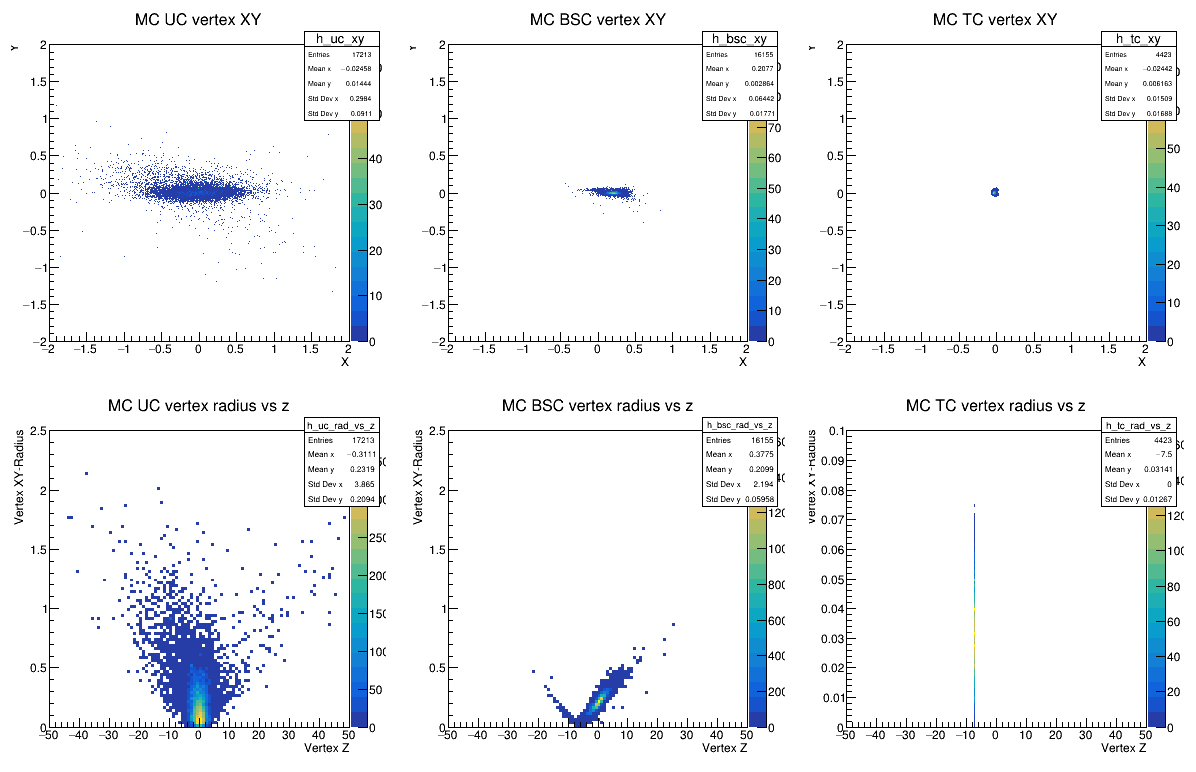

In [8]:
# plotting MC vertex position information for pairs that passed the R4 cut.
C02 = R.TCanvas("C02","C02", 1200, 800)
C02.Divide(3,2)
p1 = C02.cd(1)
h_uc_XY.Draw('colz')
p2 = C02.cd(2)
h_bsc_XY.Draw('colz')
p3 = C02.cd(3)
h_tc_XY.Draw('colz')
p4 = C02.cd(4)
h_uc_rad_vs_z.Draw('colz')
p5 = C02.cd(5)
h_bsc_rad_vs_z.Draw('colz')
p6 = C02.cd(6)
h_tc_rad_vs_z.Draw('colz')
C02.Draw()
C02.SaveAs('mc_vertex_info.pdf')

In [ ]:
# plotting Data vertex position information for pairs that passed the RX cut.
C03 = R.TCanvas("C03","C03", 1200, 800)
C03.Divide(3,2)
p1 = C03.cd(1)
h_uc_XY_data_rx.Draw('colz')
p2 = C03.cd(2)
h_bsc_XY_data_rx.Draw('colz')
p3 = C03.cd(3)
h_tc_XY_data_rx.Draw('colz')
p4 = C03.cd(4)
h_uc_rad_vs_z_data_rx.Draw('colz')
p5 = C03.cd(5)
h_bsc_rad_vs_z_data_rx.Draw('colz')
p6 = C03.cd(6)
h_tc_rad_vs_z_data_rx.Draw('colz')
C03.Draw()

In [ ]:
# plotting MC vertex position information for pairs that passed the RX cut.
C04 = R.TCanvas("C04","C04", 1200, 800)
C04.Divide(3,2)
p1 = C04.cd(1)
h_uc_XY_rx.Draw('colz')
p2 = C04.cd(2)
h_bsc_XY_rx.Draw('colz')
p3 = C04.cd(3)
h_tc_XY_rx.Draw('colz')
p4 = C04.cd(4)
h_uc_rad_vs_z_rx.Draw('colz')
p5 = C04.cd(5)
h_bsc_rad_vs_z_rx.Draw('colz')
p6 = C04.cd(6)
h_tc_rad_vs_z_rx.Draw('colz')
C04.Draw()

In [33]:
#R4 invariant mass histogram declarations for both MC and Data for all kinds of vertices.
h_r4_UC_minv_mc = df_uc.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_r4","MC R4 UC inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_r4_BSC_minv_mc = df_bsc.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_r4","MC R4 BSC inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_r4_TC_minv_mc = df_tc.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_r4","MC TC R4 inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_r4_noV_minv_mc = df_nov.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(p4minv[i]); return out;").Histo1D(("h_ee_mass_r4","MC R4 NoV inv mass; M_{inv} [GeV]",200 ,0.001,0.1),"minv")
h_r4_UC_minv_data = df_uc_data.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_r4","2021 DATA R4 UC inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_r4_BSC_minv_data = df_bsc_data.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_r4","2021 DATA R4 BSC inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_r4_TC_minv_data = df_tc_data.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_r4","2021 DATA R4 TC inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_r4_noV_minv_data = df_nov_data.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(p4minv[i]); return out;").Histo1D(("h_ee_mass_r4","2021 DATA R4 NoV inv mass; M_{inv} [GeV]",200 ,0.001,0.1),"minv")


#RX invariant mass histogram declarations for both MC and Data for all kinds of vertices.
h_rx_UC_minv_mc = df_uc.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_rx","2021 MC RX UC inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_rx_BSC_minv_mc = df_bsc.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_rx","2021 MC RX BSC inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_rx_TC_minv_mc = df_tc.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_rx","2021 MC TC RX inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_rx_noV_minv_mc = df_nov.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(p4minv[i]); return out;").Histo1D(("h_ee_mass_rx","2021 MC RX NoV inv mass; M_{inv} [GeV]",200 ,0.001,0.1),"minv")
h_rx_UC_minv_data = df_uc_data.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_rx","2021 DATA RX UC inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_rx_BSC_minv_data = df_bsc_data.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_rx","2021 DATA RX BSC inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_rx_TC_minv_data = df_tc_data.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_rx","2021 DATA RX TC inv mass; M_{inv} [GeV]",200 ,0.,0.1),"minv")
h_rx_noV_minv_data = df_nov_data.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(p4minv[i]); return out;").Histo1D(("h_ee_mass_rx","2021 DATA RX NoV inv mass; M_{inv} [GeV]",200 ,0.001,0.1),"minv")
    

### R4 Fits below.

In [24]:
#R4 fitting: routine that fits a gaussian to the core of each of the above histograms and saves the fit information.
minv_hists = [h_r4_UC_minv_mc,h_r4_BSC_minv_mc,h_r4_TC_minv_mc,h_r4_noV_minv_mc,h_r4_UC_minv_data,h_r4_BSC_minv_data,h_r4_TC_minv_data,h_r4_noV_minv_data]
means = []
means_err = []
widths = []
width_err = []
tmp = []
sigma = '\u03C3'
mu =  '\u03BC'
e = 2.718281828
for i in range(len(minv_hists)):
    hist =minv_hists[i]
    firstBin = hist.FindFirstBinAbove(hist.GetMaximum()/e)
    lastBin = hist.FindLastBinAbove(hist.GetMaximum()/e)
    x1 = hist.GetBinCenter(firstBin)
    x2 = hist.GetBinCenter(lastBin)
    gausfit  = R.TF1(f'gausfit+{i}',"gaus",x1,x2)
    hist.Fit(f'gausfit+{i}','S Q R+')
    gaus_mean = gausfit.GetParameter(1)
    gaus_mean_err = gausfit.GetParError(1)
    gaus_sigma = gausfit.GetParameter(2)
    gaus_sigma_err = gausfit.GetParError(2)
    means.append(f'{gaus_mean*1000:7.3f}')
    means_err.append(f'{gaus_mean_err*1000:7.3f}')
    widths.append(f'{gaus_sigma*1000:7.3f}')
    width_err.append(f'{gaus_sigma_err*1000:7.3f}')
    tmp.append(gaus_sigma*1000)

stat_boxes = []
for i in range(len(minv_hists)):
    x = R.TPaveText(0.50,.5,.85,.7, 'NDC')
    x.AddText(f'#mu ={means[i]}#pm{means_err[i]}MeV')
    x.AddText(f'#sigma ={widths[i]}#pm{width_err[i]}MeV')
    stat_boxes.append(x)

fit_diffs_boxes = []
for i in range(4):
    x = R.TPaveText(0.50,.5,.85,.7, 'NDC')
    dmu = float(means[i]) - float(means[i+4]) 
    dsig = float(widths[i]) - float(widths[i+4]) 
    x.AddText(f'#Delta#mu ={dmu*1:7.3f}MeV')
    x.AddText(f'#Delta#sigma ={dsig*1:7.3f}MeV')
    fit_diffs_boxes.append(x)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: C05
Info in <TCanvas::Print>: pdf file mc_r4.pdf has been created


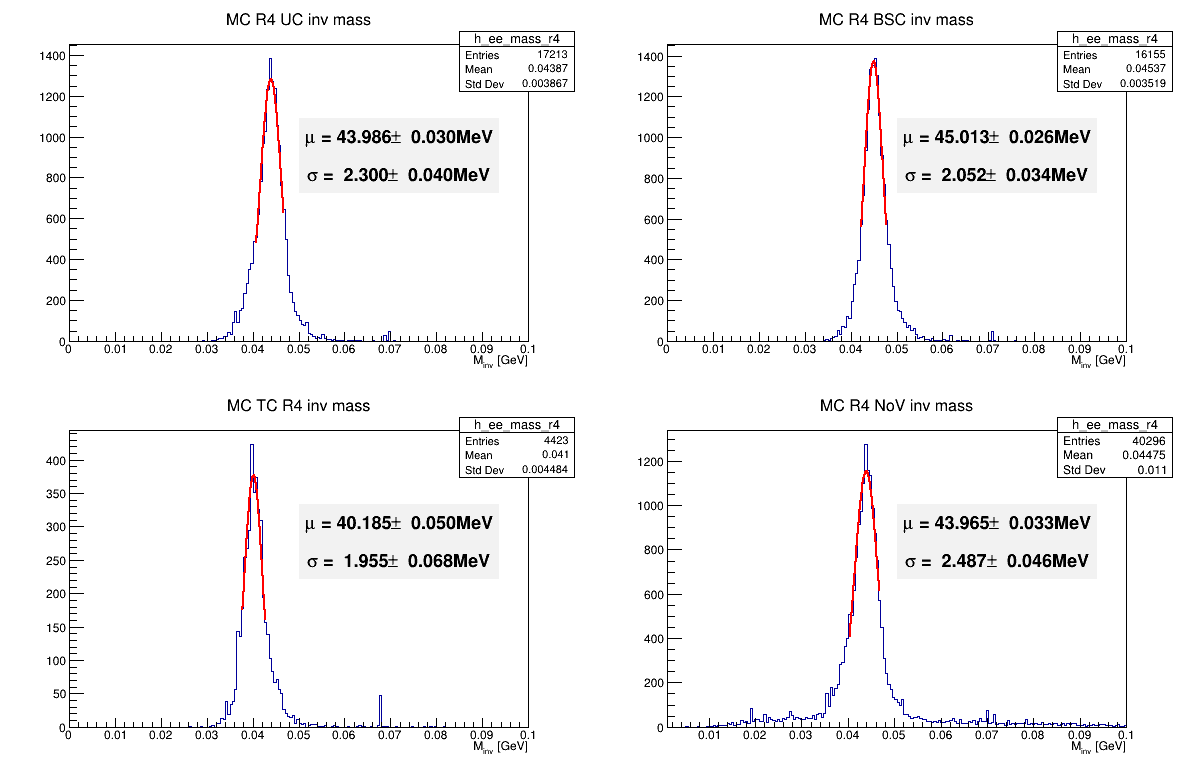

In [16]:
#plots MC R4 fits for each kind of vertex. 
C05 = R.TCanvas("C05","test",1200,800)
C05.Divide(2,2)
p1 = C05.cd(1)
h_r4_UC_minv_mc.Draw()
stat_boxes[0].Draw('same')
p2 = C05.cd(2)
h_r4_BSC_minv_mc.Draw()
stat_boxes[1].Draw('same')
p3 = C05.cd(3)
h_r4_TC_minv_mc.Draw()
stat_boxes[2].Draw('same')
p4 = C05.cd(4)
h_r4_noV_minv_mc.Draw()
stat_boxes[3].Draw('same')
C05.Draw()
C05.SaveAs('mc_r4.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: C06


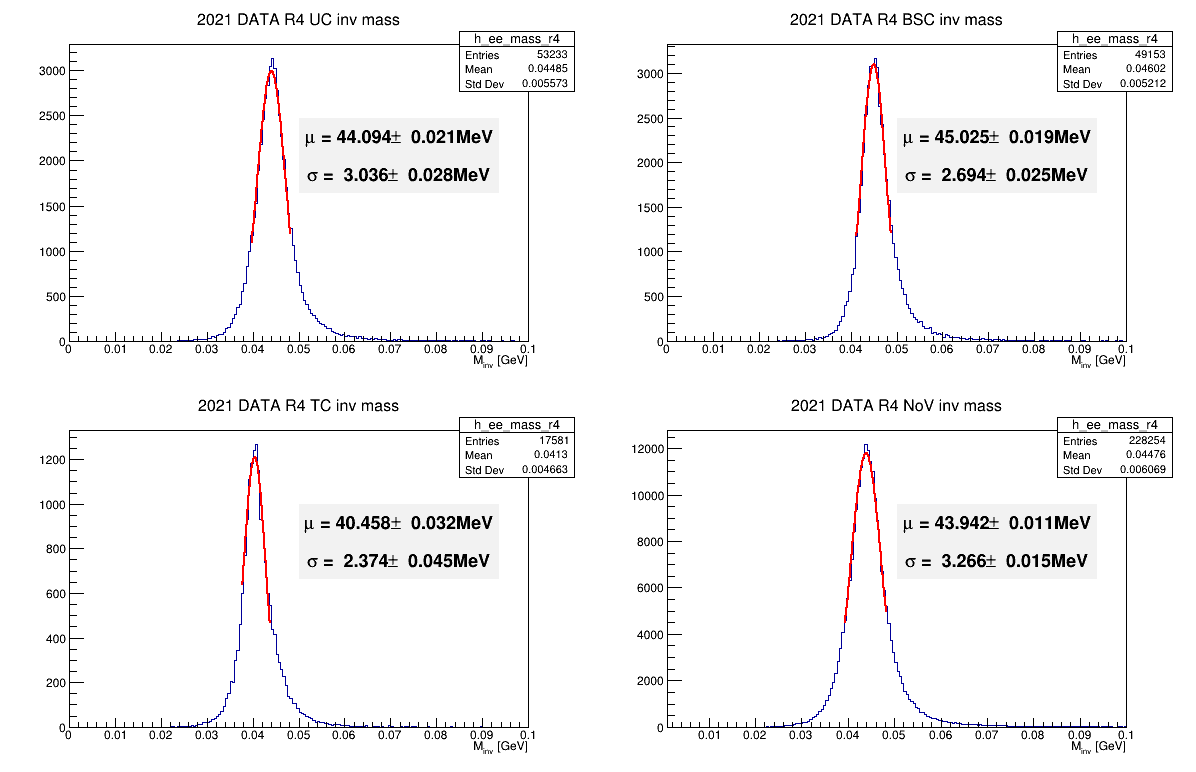

In [25]:
#plots Data R4 fits for each kind of vertex. 
C06 = R.TCanvas("C06","test",1200,800)
C06.Divide(2,2)
p1 = C06.cd(1)
h_r4_UC_minv_data.Draw()
stat_boxes[4].Draw('same')
p2 = C06.cd(2)
h_r4_BSC_minv_data.Draw()
stat_boxes[5].Draw('same')
p3 = C06.cd(3)
h_r4_TC_minv_data.Draw()
stat_boxes[6].Draw('same')
p4 = C06.cd(4)
h_r4_noV_minv_data.Draw()
stat_boxes[7].Draw('same')
C06.Draw() 

0.10472667488697082


Warning in <TCanvas::Constructor>: Deleting canvas with same name: C07
Info in <TCanvas::Print>: pdf file mc_vs_data_r4.pdf has been created


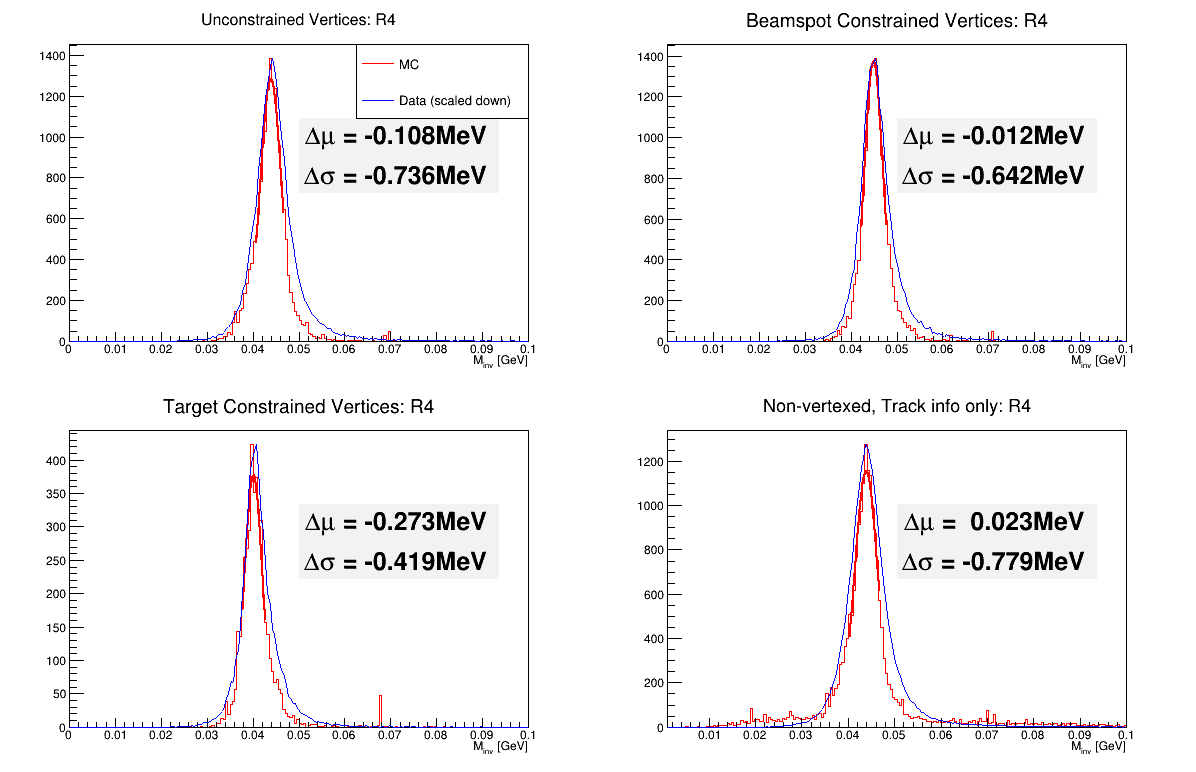

In [26]:
#plots the difference between R4 MC and Data invariant mass distributions for each kind of vertex. 
UC_scale  = h_r4_UC_minv_mc.GetMaximum()/ h_r4_UC_minv_data.GetMaximum()
BSC_scale  = h_r4_BSC_minv_mc.GetMaximum()/ h_r4_BSC_minv_data.GetMaximum()
TC_scale  = h_r4_TC_minv_mc.GetMaximum()/ h_r4_TC_minv_data.GetMaximum()
noV_scale  = h_r4_noV_minv_mc.GetMaximum()/ h_r4_noV_minv_data.GetMaximum()
print(noV_scale)
C07 = R.TCanvas("C07","test",1200,800)
C07.Divide(2,2)

p1 = C07.cd(1)
h_r4_UC_minv_mc.SetTitle('Unconstrained Vertices: R4')
h_r4_UC_minv_mc.SetStats(0)
h_r4_UC_minv_mc.SetLineColor(R.kRed)
h_r4_UC_minv_data.SetLineColor(R.kBlue)
h_r4_UC_minv_mc.Draw()
h_r4_UC_minv_data.Scale(UC_scale)
h_r4_UC_minv_data.Draw('same HIST L')
fit_diffs_boxes[0].Draw('same')
leg = R.TLegend(0.6,0.7,0.9,0.9)
leg.AddEntry(h_r4_UC_minv_mc.GetPtr(),"MC","l")
leg.AddEntry(h_r4_UC_minv_data.GetPtr(),"Data (scaled down)","l")
leg.Draw()

p2 = C07.cd(2)
h_r4_BSC_minv_mc.SetTitle('Beamspot Constrained Vertices: R4')
h_r4_BSC_minv_mc.SetStats(0)
h_r4_BSC_minv_mc.SetLineColor(R.kRed)
h_r4_BSC_minv_data.SetLineColor(R.kBlue)
h_r4_BSC_minv_mc.Draw()
h_r4_BSC_minv_data.Scale(BSC_scale)
h_r4_BSC_minv_data.Draw('same HIST L')
fit_diffs_boxes[1].Draw('same')

p3 = C07.cd(3)
h_r4_TC_minv_mc.SetTitle('Target Constrained Vertices: R4')
h_r4_TC_minv_mc.SetStats(0)
h_r4_TC_minv_mc.SetLineColor(R.kRed)
h_r4_TC_minv_data.SetLineColor(R.kBlue)
h_r4_TC_minv_mc.Draw()
h_r4_TC_minv_data.Scale(TC_scale)
h_r4_TC_minv_data.Draw('same HIST L')
fit_diffs_boxes[2].Draw('same')

p4 = C07.cd(4)
h_r4_noV_minv_mc.SetTitle('Non-vertexed, Track info only: R4')
h_r4_noV_minv_mc.SetStats(0)
h_r4_noV_minv_mc.SetLineColor(R.kRed)
h_r4_noV_minv_data.SetLineColor(R.kBlue)
h_r4_noV_minv_mc.Draw()
h_r4_noV_minv_data.Scale(noV_scale)
h_r4_noV_minv_data.Draw('same HIST L')
fit_diffs_boxes[3].Draw('same')
C07.Draw()
C07.SaveAs('mc_vs_data_r4.pdf')

### RX Fits below.

In [35]:
#RX fitting: routine that fits a gaussian to the core of each of the above histograms and saves the fit information.
minv_hists = [h_rx_UC_minv_mc,h_rx_BSC_minv_mc,h_rx_TC_minv_mc,h_rx_noV_minv_mc,h_rx_UC_minv_data,h_rx_BSC_minv_data,h_rx_TC_minv_data,h_rx_noV_minv_data]
data_fits_ball = []
data_fits_gaus = []
data_fits_gaus_err = []
means = []
means_err = []
widths = []
width_err = []
tmp = []
sigma = '\u03C3'
mu =  '\u03BC'
e = 2.718281828
for i in range(len(minv_hists)):
    hist =minv_hists[i]
    firstBin = hist.FindFirstBinAbove(hist.GetMaximum()/3)
    lastBin = hist.FindLastBinAbove(hist.GetMaximum()/3)
    x1 = hist.GetBinCenter(firstBin)
    x2 = hist.GetBinCenter(lastBin)
    gausfit  = R.TF1(f'gausfit+{i}',"gaus",x1,x2)
    hist.Fit(f'gausfit+{i}','S Q R+')
    gaus_mean = gausfit.GetParameter(1)
    gaus_mean_err = gausfit.GetParError(1)
    gaus_sigma = gausfit.GetParameter(2)
    gaus_sigma_err = gausfit.GetParError(2)
    means.append(f'{gaus_mean*1000:7.3f}')
    means_err.append(f'{gaus_mean_err*1000:7.3f}')
    widths.append(f'{gaus_sigma*1000:7.3f}')
    width_err.append(f'{gaus_sigma_err*1000:7.3f}')
    tmp.append(gaus_sigma*1000)

stat_boxes = []
for i in range(len(minv_hists)):
    x = R.TPaveText(0.50,.5,.85,.7, 'NDC')
    x.AddText(f'#mu ={means[i]}#pm{means_err[i]}MeV')
    x.AddText(f'#sigma ={widths[i]}#pm{width_err[i]}MeV')
    stat_boxes.append(x)

fit_diffs_boxes = []
for i in range(4):
    x = R.TPaveText(0.50,.5,.85,.7, 'NDC')
    dmu = float(means[i]) - float(means[i+4]) 
    dsig = float(widths[i]) - float(widths[i+4]) 
    x.AddText(f'#Delta#mu ={dmu*1:7.3f}MeV')
    x.AddText(f'#Delta#sigma ={dsig*1:7.3f}MeV')
    fit_diffs_boxes.append(x)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: C08
Info in <TCanvas::Print>: pdf file mc_rx.pdf has been created


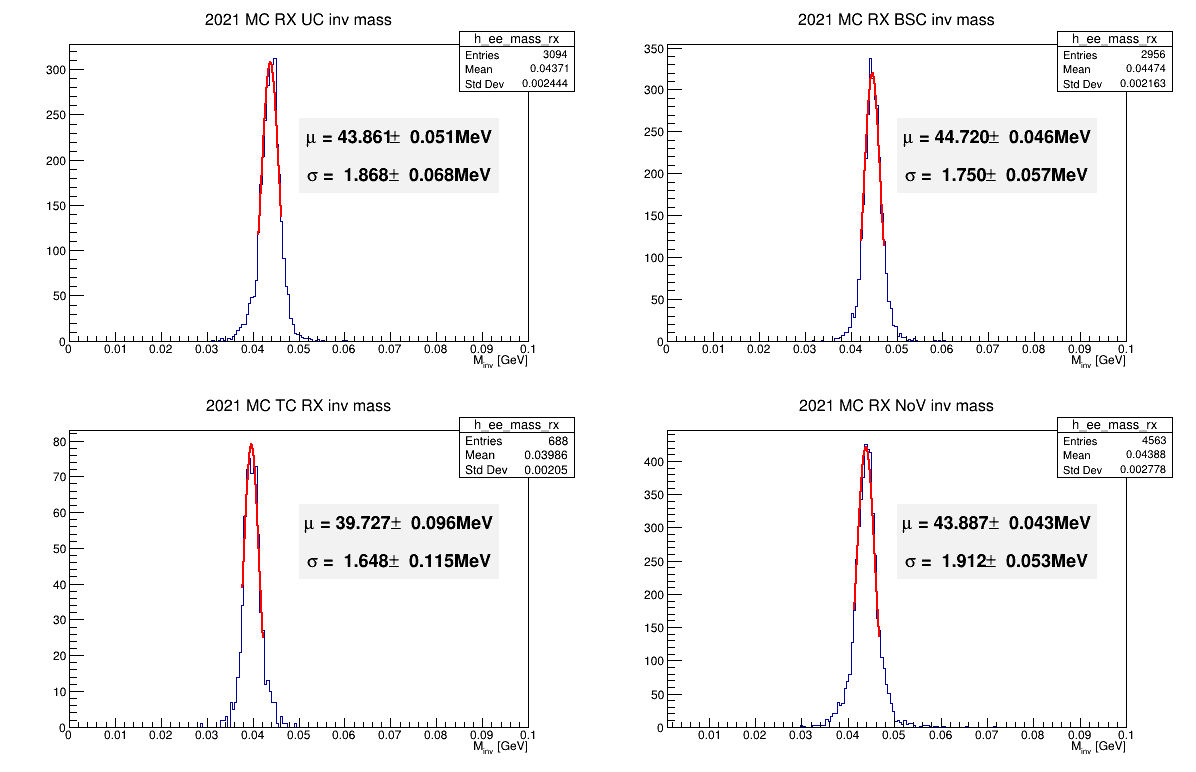

In [36]:
#plots for MC RX fits.
C08 = R.TCanvas("C08","test",1200,800)
C08.Divide(2,2)
p1 = C08.cd(1)
h_rx_UC_minv_mc.Draw()
stat_boxes[0].Draw('same')
p2 = C08.cd(2)
h_rx_BSC_minv_mc.Draw()
stat_boxes[1].Draw('same')
p3 = C08.cd(3)
h_rx_TC_minv_mc.Draw()
stat_boxes[2].Draw('same')
p4 = C08.cd(4)
h_rx_noV_minv_mc.Draw()
stat_boxes[3].Draw('same')
C08.Draw()
C08.SaveAs('mc_rx.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: C09
Info in <TCanvas::Print>: pdf file data_rx.pdf has been created


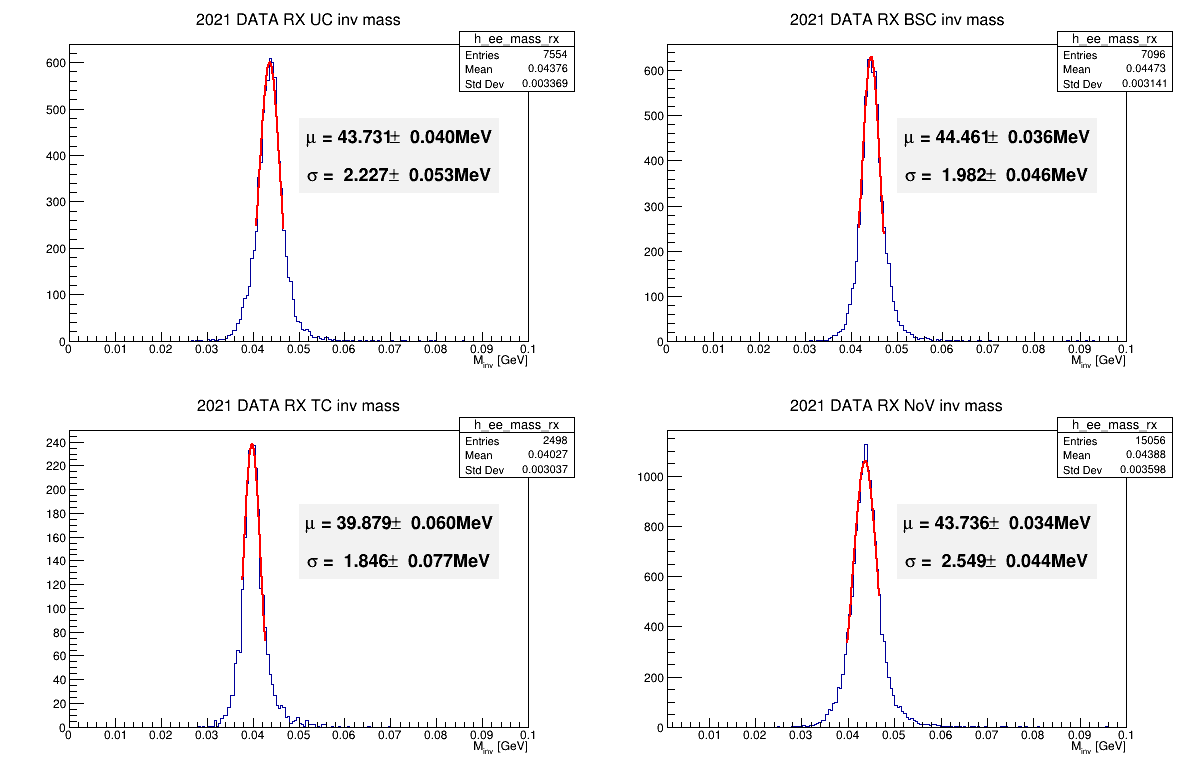

In [37]:
#plots for Data RX Fits.
C09 = R.TCanvas("C09","test",1200,800)
C09.Divide(2,2)
p1 = C09.cd(1)
h_rx_UC_minv_data.Draw()
stat_boxes[4].Draw('same')
p2 = C09.cd(2)
h_rx_BSC_minv_data.Draw()
stat_boxes[5].Draw('same')
p3 = C09.cd(3)
h_rx_TC_minv_data.Draw()
stat_boxes[6].Draw('same')
p4 = C09.cd(4)
h_rx_noV_minv_data.Draw()
stat_boxes[7].Draw('same')
C09.Draw()
C09.SaveAs('data_rx.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: C10
Info in <TCanvas::Print>: pdf file mc_vs_data_rx.pdf has been created


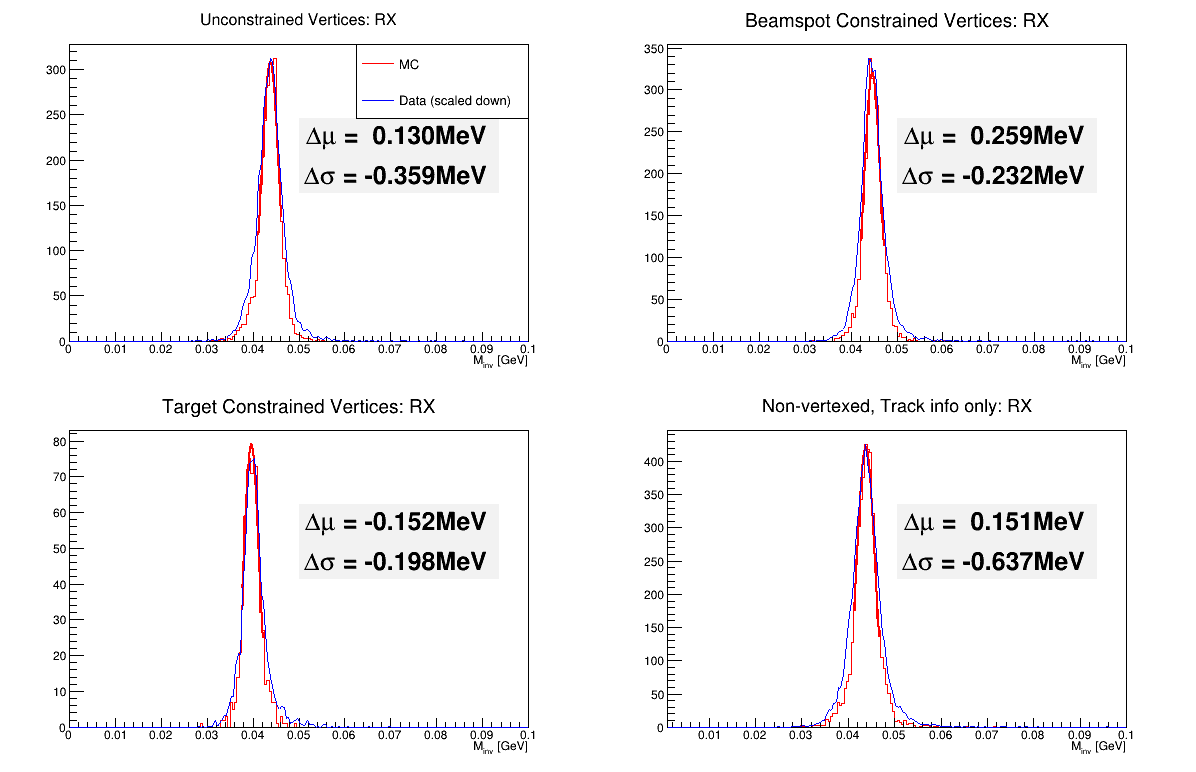

In [38]:
#plots the difference between RX MC and Data invariant mass distributions for each kind of vertex. 
UC_scale_rx  = h_rx_UC_minv_mc.GetMaximum()/ h_rx_UC_minv_data.GetMaximum()
BSC_scale_rx  = h_rx_BSC_minv_mc.GetMaximum()/ h_rx_BSC_minv_data.GetMaximum()
TC_scale_rx  = h_rx_TC_minv_mc.GetMaximum()/ h_rx_TC_minv_data.GetMaximum()
noV_scale_rx  = h_rx_noV_minv_mc.GetMaximum()/ h_rx_noV_minv_data.GetMaximum()

C10 = R.TCanvas("C10","test",1200,800)
C10.Divide(2,2)

p1 = C10.cd(1)
h_rx_UC_minv_mc.SetTitle('Unconstrained Vertices: RX')
h_rx_UC_minv_mc.SetStats(0)
h_rx_UC_minv_mc.SetLineColor(R.kRed)
h_rx_UC_minv_data.SetLineColor(R.kBlue)
h_rx_UC_minv_mc.Draw()
h_rx_UC_minv_data.Scale(UC_scale_rx)
h_rx_UC_minv_data.Draw('same HIST L')
fit_diffs_boxes[0].Draw('same')
leg = R.TLegend(0.6,0.7,0.9,0.9)
leg.AddEntry(h_rx_UC_minv_mc.GetPtr(),"MC","l")
leg.AddEntry(h_rx_UC_minv_data.GetPtr(),"Data (scaled down)","l")
leg.Draw()

p2 = C10.cd(2)
h_rx_BSC_minv_mc.SetTitle('Beamspot Constrained Vertices: RX')
h_rx_BSC_minv_mc.SetStats(0)
h_rx_BSC_minv_mc.SetLineColor(R.kRed)
h_rx_BSC_minv_data.SetLineColor(R.kBlue)
h_rx_BSC_minv_mc.Draw()
h_rx_BSC_minv_data.Scale(BSC_scale_rx)
h_rx_BSC_minv_data.Draw('same HIST L')
fit_diffs_boxes[1].Draw('same')

p3 = C10.cd(3)
h_rx_TC_minv_mc.SetTitle('Target Constrained Vertices: RX')
h_rx_TC_minv_mc.SetStats(0)
h_rx_TC_minv_mc.SetLineColor(R.kRed)
h_rx_TC_minv_data.SetLineColor(R.kBlue)
h_rx_TC_minv_mc.Draw()
h_rx_TC_minv_data.Scale(TC_scale_rx)
h_rx_TC_minv_data.Draw('same HIST L')
fit_diffs_boxes[2].Draw('same')

p4 = C10.cd(4)
h_rx_noV_minv_mc.SetTitle('Non-vertexed, Track info only: RX')
h_rx_noV_minv_mc.SetStats(0)
h_rx_noV_minv_mc.SetLineColor(R.kRed)
h_rx_noV_minv_data.SetLineColor(R.kBlue)
h_rx_noV_minv_mc.Draw()
h_rx_noV_minv_data.Scale(noV_scale_rx)
h_rx_noV_minv_data.Draw('same HIST L') 
fit_diffs_boxes[3].Draw('same')
C10.Draw()
C10.SaveAs('mc_vs_data_rx.pdf')

### WIDER TIMING -- "Not Mollers"

In [39]:
# new dfs for in time (IT) and out of time (OOT) electron pairs. Just looking at UC v0s here, and only with Data since MC has a pre-performed timing cut when a vertex is made.
Beam_Energy = 1.9
df_uc = Moller.Select_v0(R.RDF.AsRNode(df_moller_beam), 4, 0., 2.5,"pairs") \
    .Define("n_moller_pair","return pairs_idx.size();").Filter("n_moller_pair >= 1")

df_uc_data = Moller.Select_v0(R.RDF.AsRNode(df_data), 4, 0., 2.5,"pairs") \
    .Define("n_moller_pair","return pairs_idx.size();").Filter("n_moller_pair >= 1")

df_uc_OOT = Moller.Select_v0 (R.RDF.AsRNode(df_moller_beam), 4, 6., 50.,"pairs") \
    .Define("n_moller_pair","return pairs_idx.size();").Filter("n_moller_pair >= 1")

df_uc_data_OOT = Moller.Select_v0(R.RDF.AsRNode(df_data), 4, 6., 50.,"pairs") \
    .Define("n_moller_pair","return pairs_idx.size();").Filter("n_moller_pair >= 1")

In [40]:
#perform cuts.
data_set = [df_uc,df_uc_OOT,df_uc_data,df_uc_data_OOT ]
for i in range(len(data_set)):
    data_set[i] = Moller.Add_Four_Vectors(R.RDF.AsRNode(data_set[i]), -0.0302, "pairs","part_","p4")
    data_set[i] = Moller.Refine_El_Pairs_1(R.RDF.AsRNode(data_set[i]), 1.7, Beam_Energy*0., Beam_Energy*2., "pairs", "pairs_idx", "pairs_r1")
    data_set[i] = Moller.Refine_El_Pairs_2(R.RDF.AsRNode(data_set[i]), "pairs", "pairs_r1", "pairs_r2")
    data_set[i] = Moller.Refine_El_Pairs_3(R.RDF.AsRNode(data_set[i]), 0.01, "pairs_r2", "p4", "pairs_r3")
    data_set[i] = Moller.Refine_El_Pairs_1(R.RDF.AsRNode(data_set[i]), 2.0, Beam_Energy*0.85, Beam_Energy*1.1, "pairs", "pairs_r3", "pairs_r4")
    data_set[i] = Moller.Refine_El_Pairs_X2(R.RDF.AsRNode(data_set[i]), "pairs", "pairs_r4", "pairs_rx")


[df_uc,df_uc_OOT,df_uc_data,df_uc_data_OOT ] = data_set

In [41]:
#histogram declarations to look at track timing for above dfs.
h_mc_intime = df_uc.Define("dt","vector<double> out; for(int i=0; i<v0_type.size();++i){if(v0_type[i]==4){double tr_dtime=(track_time[v0_em_track[i]]-track_time[v0_ep_track[i]]); out.push_back(tr_dtime);} } return out;").Histo1D(("h_v0_time_diff1","V0 type 4 Track time diff",500,-100,100),"dt")
h_mc_outoftime = df_uc_OOT.Define("dt","vector<double> out; for(int i=0; i<v0_type.size();++i){if(v0_type[i]==4){double tr_dtime=(track_time[v0_em_track[i]]-track_time[v0_ep_track[i]]); out.push_back(tr_dtime);} } return out;").Histo1D(("h_v0_time_diff2","V0 type 4 Track time diff",500,-100,100),"dt")

h_data_intime = df_uc_data.Define("dt","vector<double> out; for(int i=0; i<v0_type.size();++i){if(v0_type[i]==4){double tr_dtime=(track_time[v0_em_track[i]]-track_time[v0_ep_track[i]]); out.push_back(tr_dtime);} } return out;").Histo1D(("h_v0_time_diff3","V0 type 4 Track time diff",500,-100,100),"dt")
h_data_outoftime = df_uc_data_OOT.Define("dt","vector<double> out; for(int i=0; i<v0_type.size();++i){if(v0_type[i]==4){double tr_dtime=(track_time[v0_em_track[i]]-track_time[v0_ep_track[i]]); out.push_back(tr_dtime);} } return out;").Histo1D(("h_v0_time_diff4","V0 type 4 Track time diff",500,-100,100),"dt")



Info in <TCanvas::Print>: pdf file dtracktime.pdf has been created


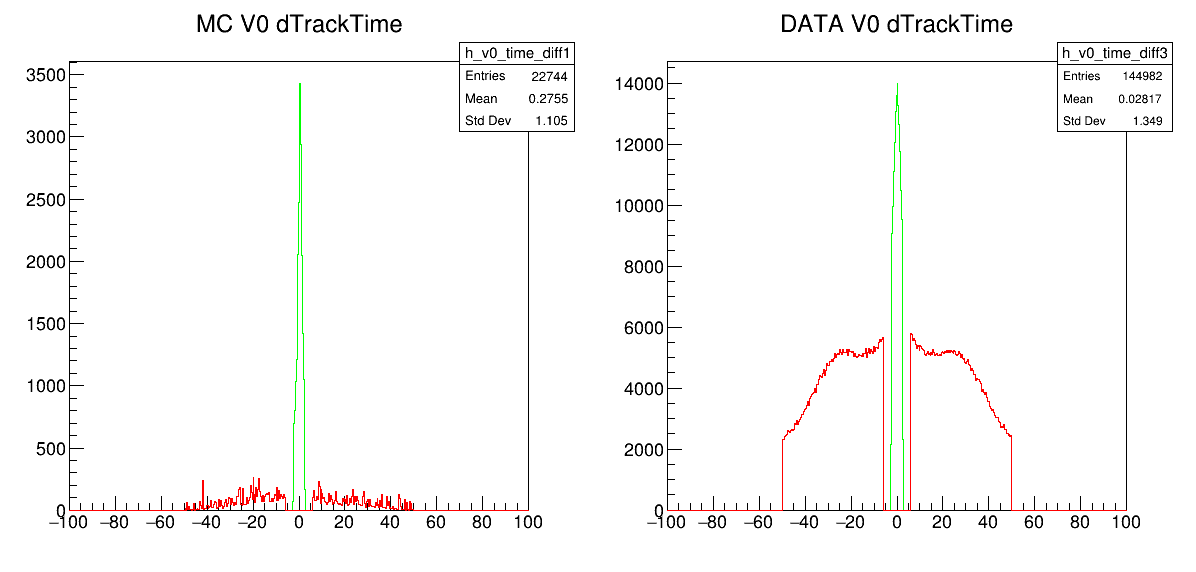

In [42]:
C11 = R.TCanvas("C11","C11",1200,600)
C11.Divide(2,1)
p1 = C11.cd(1)
h_mc_intime.SetTitle("MC V0 dTrackTime")
h_mc_intime.SetLineColor(R.kGreen)
h_mc_intime.Draw()
h_mc_outoftime.SetLineColor(R.kRed)
h_mc_outoftime.Draw('same')
p2 = C11.cd(2)
h_data_intime.SetTitle("DATA V0 dTrackTime")
h_data_intime.SetLineColor(R.kGreen)
h_data_intime.Draw()
h_data_outoftime.SetLineColor(R.kRed)
h_data_outoftime.Draw('same')
C11.Draw()
C11.SaveAs('dtracktime.pdf')

In [43]:
#R4 plots for IT and OOT UC_v0 pairs.

h_r4_UC_minv_mc_IT = df_uc.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_r4","MC R4: in time UC inv mass; M_{inv} [GeV]",250,0.,0.2),"minv")
h_r4_UC_minv_mc_OOT = df_uc_OOT.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_r4","MC R4: out of time UC inv mass; M_{inv} [GeV]",250,0.,0.2),"minv")
h_r4_UC_minv_data_IT = df_uc_data.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_r4","2021 DATA R4: in time UC inv mass; M_{inv} [GeV]",250,0.,0.2),"minv")
h_r4_UC_minv_data_OOT = df_uc_data_OOT.Define("minv","vector<double> out;for(int i: pairs_r4) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_r4","2021 DATA R4: out of time UC inv mass; M_{inv} [GeV]",250,0.,0.2),"minv")

#same thing but for RX.
h_rx_UC_minv_mc_IT = df_uc.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_rx","MC RX: In Time UC inv mass; M_{inv} [GeV]",250,0.,0.2),"minv")
h_rx_UC_minv_mc_OOT = df_uc_OOT.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_rx","MC RX: Out-of-time UC inv mass; M_{inv} [GeV]",250,0.,0.2),"minv")
h_rx_UC_minv_data_IT = df_uc_data.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_rx","2021 DATA RX: in time UC inv mass; M_{inv} [GeV]",250,0.,0.2),"minv")
h_rx_UC_minv_data_OOT = df_uc_data_OOT.Define("minv","vector<double> out;for(int i: pairs_rx) out.push_back(v0_mass[i]); return out;").Histo1D(("h_ee_mass_rx","2021 DATA RX: out of time UC inv mass; M_{inv} [GeV]",100,0.,0.2),"minv")



In [44]:

minv_hists = [h_r4_UC_minv_mc_IT,h_r4_UC_minv_mc_OOT,h_r4_UC_minv_data_IT,h_r4_UC_minv_data_OOT,h_rx_UC_minv_mc_IT,h_rx_UC_minv_mc_OOT,h_rx_UC_minv_data_IT,h_rx_UC_minv_data_OOT]
data_fits_ball = []
data_fits_gaus = []
data_fits_gaus_err = []
means = []
means_err = []
widths = []
width_err = []
tmp = []
sigma = '\u03C3'
mu =  '\u03BC'
e = 2.718281828
for i in range(len(minv_hists)):
    hist =minv_hists[i]
    firstBin = hist.FindFirstBinAbove(hist.GetMaximum()/6)
    lastBin = hist.FindLastBinAbove(hist.GetMaximum()/4)
    x1 = hist.GetBinCenter(firstBin)
    x2 = hist.GetBinCenter(lastBin)
    gausfit  = R.TF1(f'gausfit+{i}',"gaus",x1,x2)
    hist.Fit(f'gausfit+{i}','S Q R+ ')
    gaus_mean = gausfit.GetParameter(1)
    gaus_mean_err = gausfit.GetParError(1)
    gaus_sigma = gausfit.GetParameter(2)
    gaus_sigma_err = gausfit.GetParError(2)
    means.append(f'{gaus_mean*1000:7.3f}')
    means_err.append(f'{gaus_mean_err*1000:7.3f}')
    widths.append(f'{gaus_sigma*1000:7.3f}')
    width_err.append(f'{gaus_sigma_err*1000:7.3f}')
    tmp.append(gaus_sigma*1000)

stat_boxes = []
for i in range(len(minv_hists)):
    x = R.TPaveText(0.50,.5,.85,.7, 'NDC')
    x.AddText(f'#mu ={means[i]}#pm{means_err[i]}MeV')
    x.AddText(f'#sigma ={widths[i]}#pm{width_err[i]}MeV')
    stat_boxes.append(x)

Info in <TCanvas::Print>: pdf file data_IT_OOT.pdf has been created


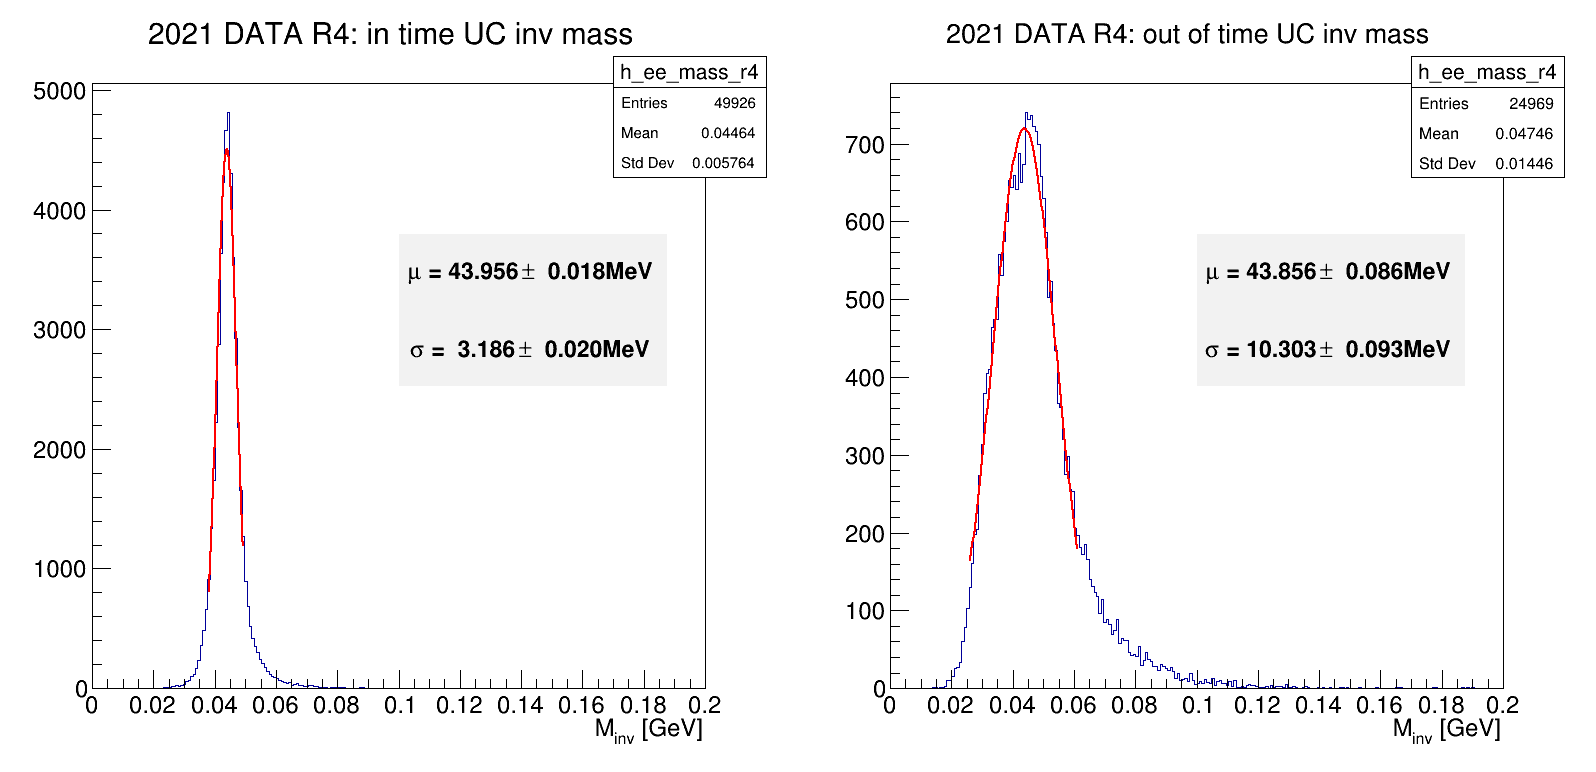

In [45]:
#plot IT and OOT fits for r4.
C12 = R.TCanvas("C12","test",1600,800)
C12.Divide(2,1)
p1 = C12.cd(1)
h_r4_UC_minv_data_IT.Draw()
stat_boxes[2].Draw('same')
p2 = C12.cd(2)
h_r4_UC_minv_data_OOT.Draw()
stat_boxes[3].Draw('same')
C12.Draw()
C12.SaveAs('data_IT_OOT_r4.pdf')

Info in <TCanvas::Print>: pdf file data_IT_OOT_rx.pdf has been created


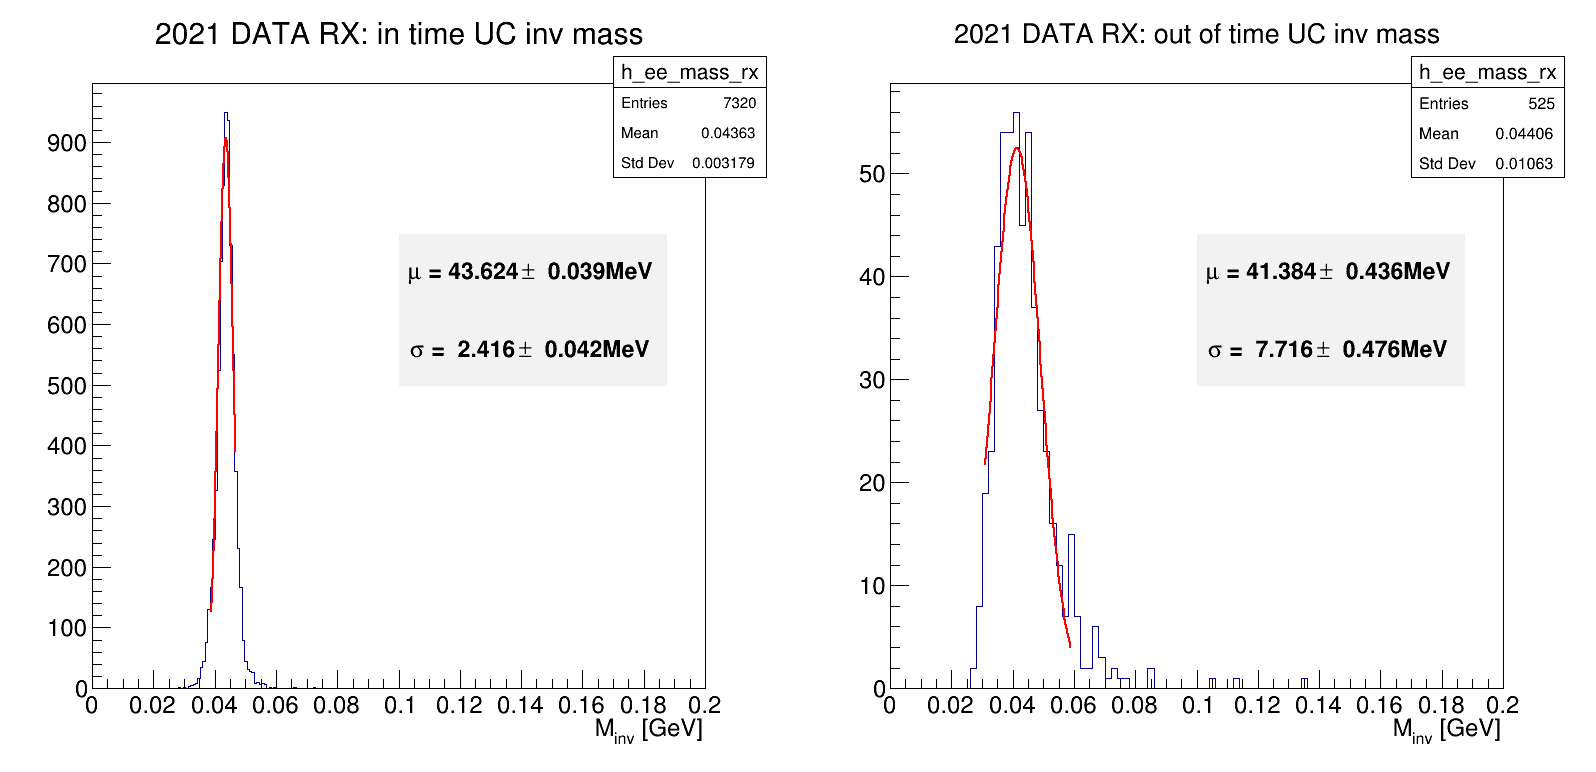

In [46]:
#plot IT and OOT fits for rx.
C13 = R.TCanvas("C13","test",1600,800)
C13.Divide(2,1)
p1 = C13.cd(1)
h_rx_UC_minv_data_IT.Draw()
stat_boxes[6].Draw('same')
p2 = C13.cd(2)
h_rx_UC_minv_data_OOT.Draw()
stat_boxes[7].Draw('same')
C13.Draw()
C13.SaveAs('data_IT_OOT_rx.pdf')